# Problem Description: Using Clustering Methods in Unsupervised Learning to Identify Cohorts of Related Patients for Heart Disease treatment

In this project, I will be doing a submission for [This Kaggle Competition](https://www.kaggle.com/competitions/k-means-clustering-for-heart-disease-analysis/overview) that uses data on patients diagnosed with heart disease from the V.A. Medical Center in Long Beach, California. The submission to Kaggle uses a log-loss scoring method to compare the submission with the diagnosis groups that the patients were ultimately sorted into, the goal will be to identify patients into different clusters correctly such that the log-loss score is minimized. These patient records are not labelled, meaning that we will be using unsupervised learning (Principal component analysis and KMeans) in order to identify target groups. 

# EDA and Data Cleaning

As is common with medical data, there are many missing data points in this dataset, as not all of the patients will have all of the same tests performed. We will need to run through each of the different values in this data and decide the best way to impute the missing data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # stops annoying (and unactionable) memory-leak warning for KMeans when run on Windows

In [4]:
df = pd.read_csv('heart_disease.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB


In [6]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000
mean,459.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653
min,0.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,229.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000
50%,459.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000
75%,689.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000
max,919.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000


In [7]:
df.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

In [8]:
numeric = df[['age','trestbps','chol','thalch','oldpeak','ca']]
numeric_clean = numeric.dropna()
numeric_clean.corr()

,age,trestbps,chol,thalch,oldpeak,ca
age,1.000000,0.290016,0.106559,-0.392695,0.192442,0.372018
trestbps,0.290016,1.000000,0.107461,-0.056328,0.197292,0.094925
chol,0.106559,0.107461,1.000000,0.091528,0.048730,0.051606
thalch,-0.392695,-0.056328,0.091528,1.000000,-0.332752,-0.265275
oldpeak,0.192442,0.197292,0.048730,-0.332752,1.000000,0.280301
ca,0.372018,0.094925,0.051606,-0.265275,0.280301,1.000000


## Missing Values

As with much medical data, we can't rely on every single useful column being available to us for every patient, so we'll need to figure out what to do on a case-by-case basis.

### Resting Blood Pressure (trestbps) 

array([[<Axes: title={'center': 'trestbps'}>]], dtype=object)

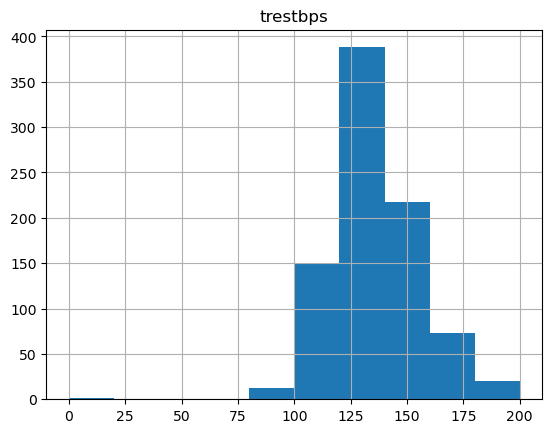

In [11]:
df[['trestbps']].hist()

array([[<Axes: title={'center': 'trestbps'}>]], dtype=object)

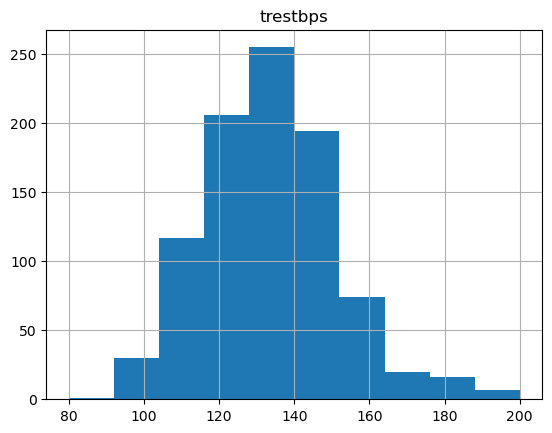

In [12]:
# impute with mean value
# remove outlier from mean calculation
bpsdf = df[df['trestbps'] > 50]
bpsAvg = np.mean(bpsdf['trestbps'])
df[['trestbps']] = df[['trestbps']].fillna(bpsAvg)
df[['trestbps']] = df[['trestbps']].replace(0,bpsAvg)
df[['trestbps']].hist()

### Cholesterol (chol)

array([[<Axes: title={'center': 'chol'}>]], dtype=object)

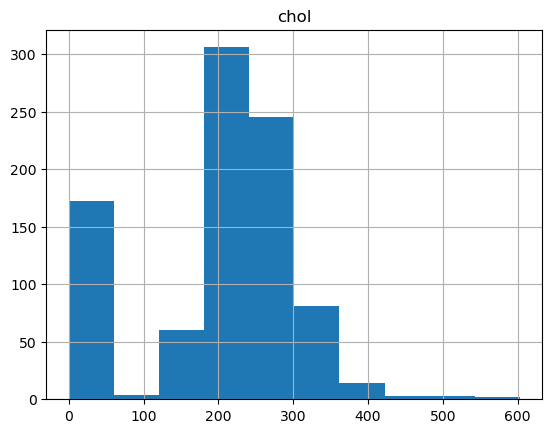

In [14]:
df[['chol']].hist()

array([[<Axes: title={'center': 'chol'}>]], dtype=object)

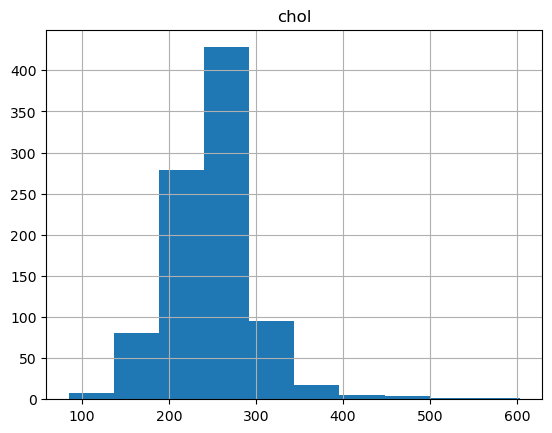

In [15]:
# Cholesterol is likely not 0! these zero values should also be treated as null.
# since the cholesterol level is not strongly correlated with age, we should impute the average cholesterol dropping zeroes
choldf = df[df['chol'] > 0]
cholAvg = np.mean(choldf['chol'])
df[['chol']] = df[['chol']].fillna(cholAvg)
df[['chol']] = df[['chol']].replace(0,cholAvg)
df[['chol']].hist()

### fasting blood sugar > 120 mg/dl (fbs)

<Axes: xlabel='fbs'>

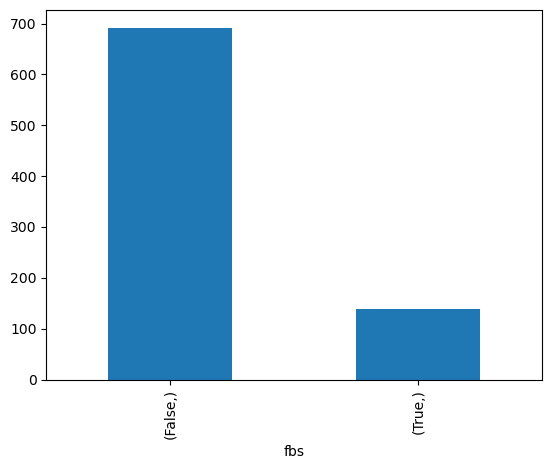

In [17]:
df[['fbs']].value_counts().plot(kind='bar')

In [18]:
# most of these are false, let's imput false for the blanks
df[['fbs']] = df[['fbs']].fillna('False')

### resting electrocardiographic results (restecg)

<Axes: xlabel='restecg'>

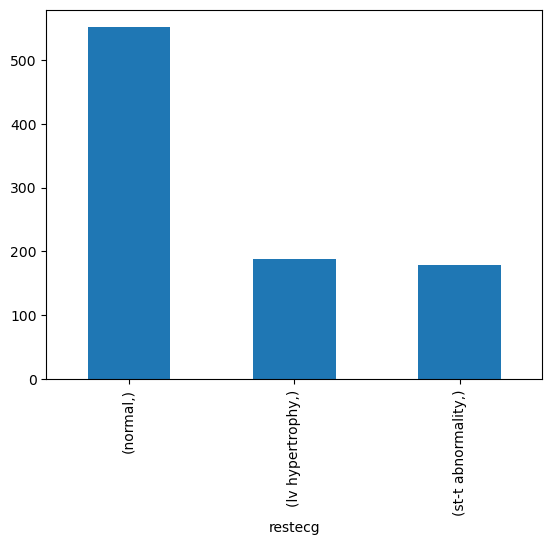

In [20]:
df[['restecg']].value_counts().plot(kind='bar')

In [21]:
# we only have two missing, let's set them to "normal"
df[['restecg']] = df[['restecg']].fillna('normal')

### maximum heart rate achieved (thalch)

array([[<Axes: title={'center': 'thalch'}>]], dtype=object)

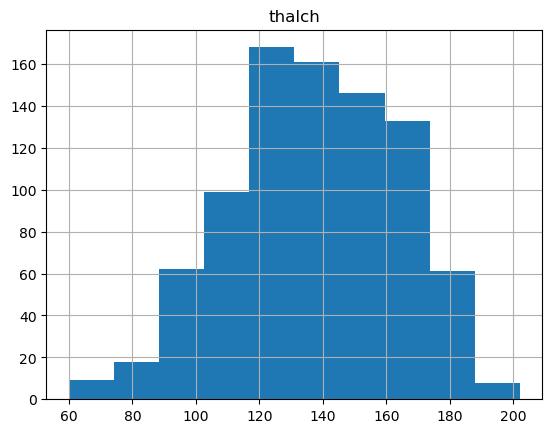

In [23]:
df[['thalch']].hist()

In [24]:
thalchAvg = np.mean(df['thalch'])
df[['thalch']] = df[['thalch']].fillna(thalchAvg)

### exercise angina (exang)

<Axes: xlabel='exang'>

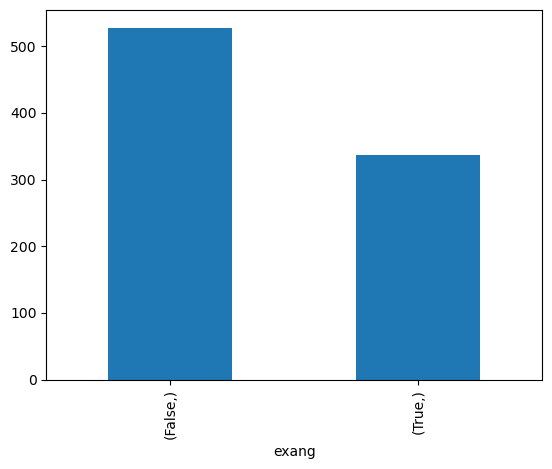

In [26]:
df[['exang']].value_counts().plot(kind='bar')

In [27]:
df[['exang']] = df[['exang']].fillna('False')

### ST depression induced by exercise relative to rest 	(oldpeak)

array([[<Axes: title={'center': 'oldpeak'}>]], dtype=object)

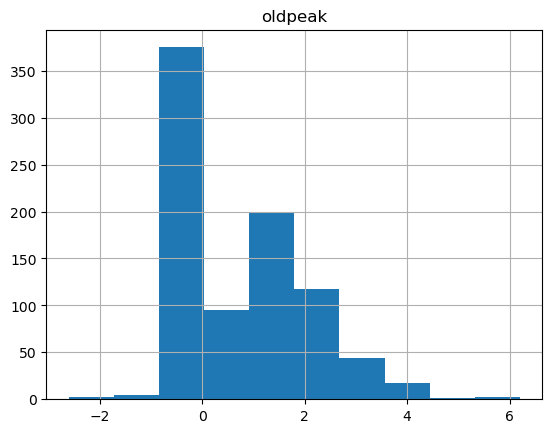

In [29]:
df[['oldpeak']].hist()

array([[<Axes: title={'center': 'oldpeak'}>]], dtype=object)

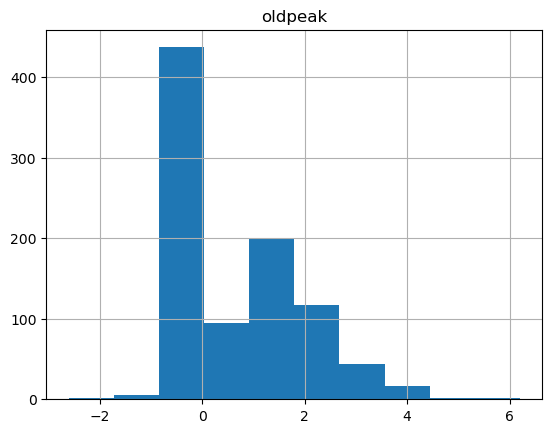

In [30]:
opAvg = np.mean(df['oldpeak'])
df[['oldpeak']] = df[['oldpeak']].fillna(0)
df[['oldpeak']].hist()

### slope of the peak exercise ST segment (slope)

<Axes: xlabel='slope'>

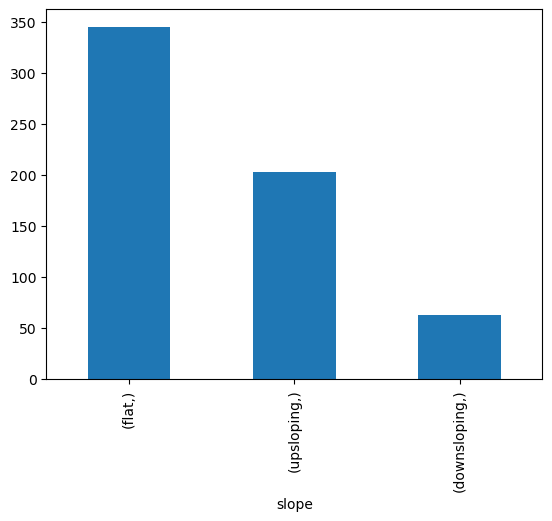

In [32]:
df[['slope']].value_counts().plot(kind='bar')

In [33]:
df[['slope']] = df[['slope']].fillna('unknown')

### number of major vessels ('ca')

array([[<Axes: title={'center': 'ca'}>]], dtype=object)

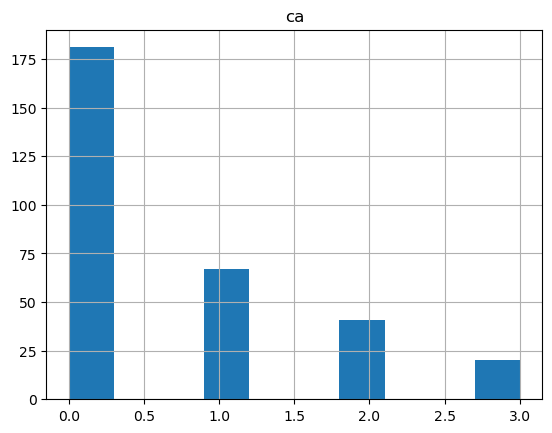

In [35]:
df[['ca']].hist()

In [36]:
# fill deficient clinically relevant tests with empty value
df[['ca']] = df[['ca']].fillna(-1)

### thalassemia ('thal')

<Axes: xlabel='thal'>

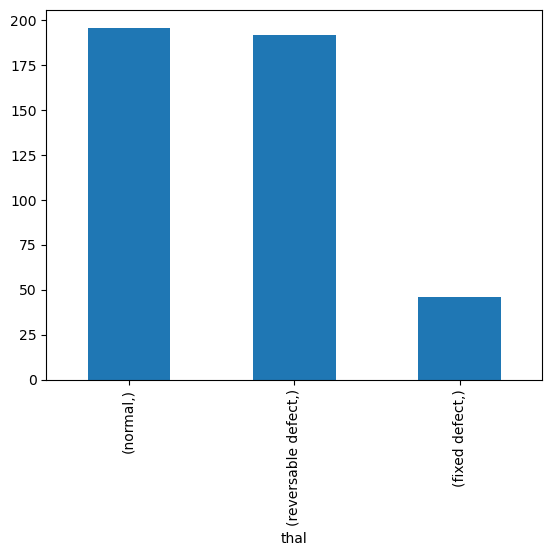

In [38]:
df[['thal']].value_counts().plot(kind='bar')

In [39]:
# fill deficient clinically relevant tests with unkown value
df[['thal']] = df[['thal']].fillna('unknown')

In [40]:
df.isna().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

## Not Missing Values

array([[<Axes: title={'center': 'age'}>]], dtype=object)

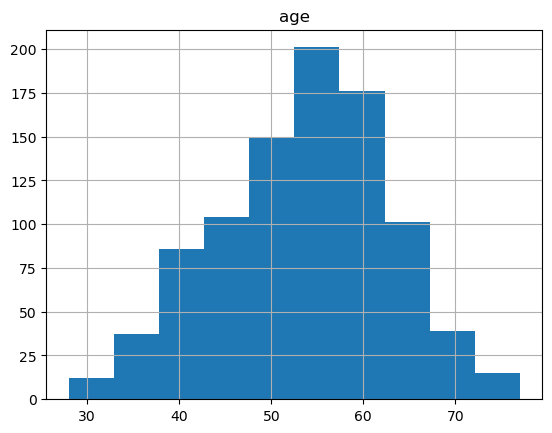

In [42]:
df[['age']].hist()

<Axes: xlabel='sex'>

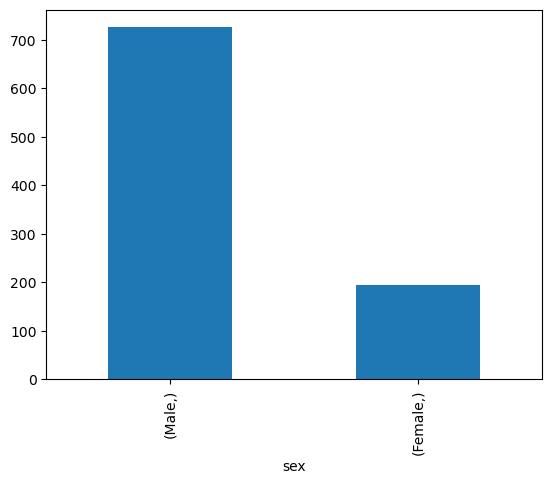

In [43]:
df[['sex']].value_counts().plot(kind='bar')

<Axes: xlabel='dataset'>

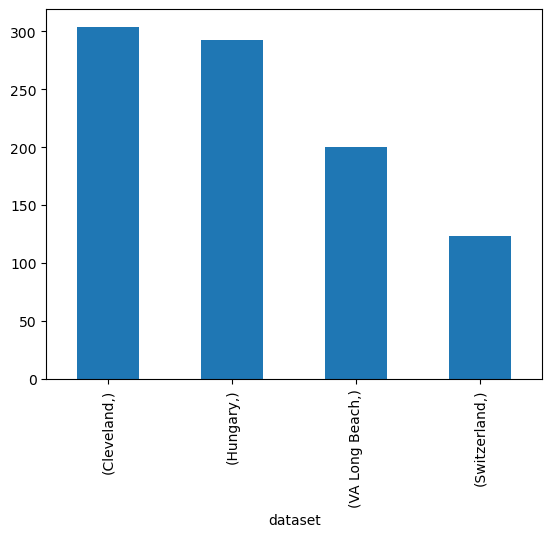

In [44]:
df[['dataset']].value_counts().plot(kind='bar')

### Chest pain type

<Axes: xlabel='cp'>

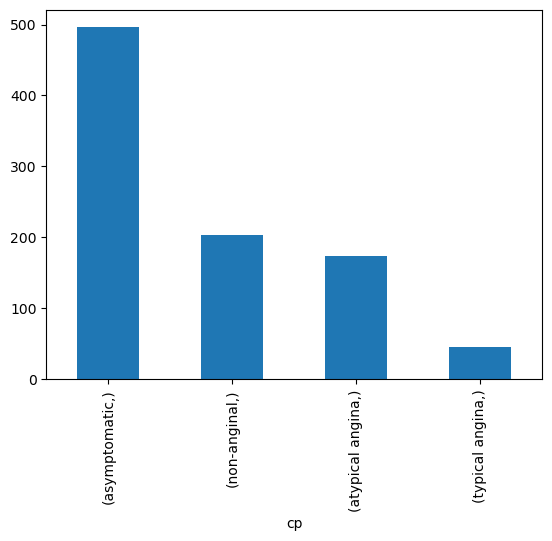

In [46]:
df[['cp']].value_counts().plot(kind='bar') 

# Preprocessing

In [48]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder() # encode using ordinal values for multi-value categories

for col in df:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str)
        df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

feature_df = df.drop(['id','dataset'],axis=1) #id and where the patient data ultimately originate from shouldn't matter for analysis

# Modeling

In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Principal Component Analysis

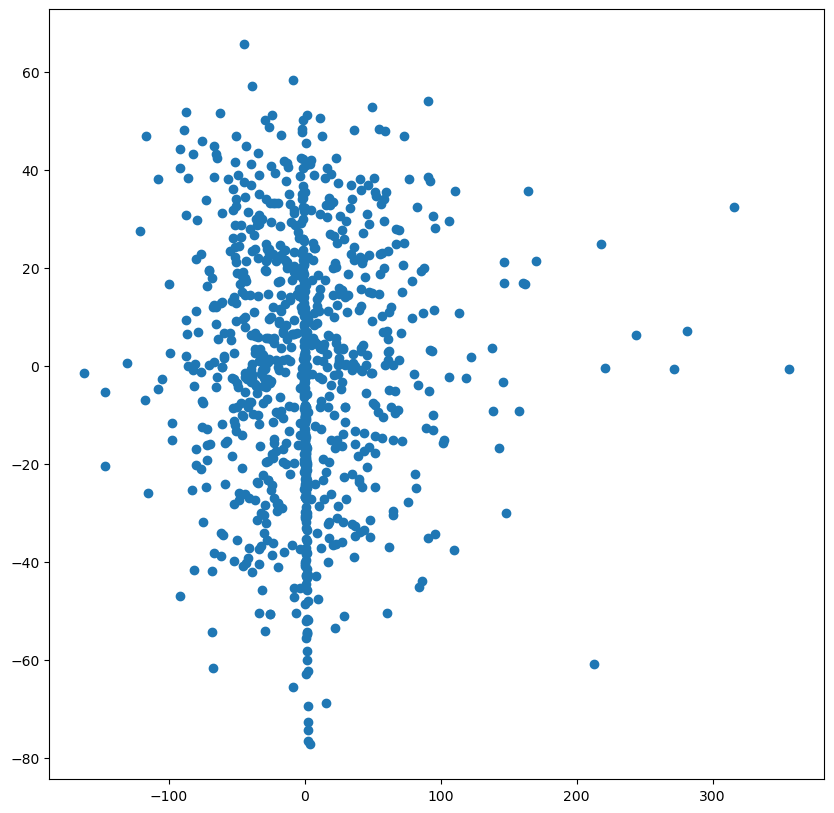

In [52]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(feature_df)
plt.figure(figsize=(10, 10))
plt.scatter(x=pca_data[:, 0], y=pca_data[:, 1])
plt.show()

The straight-line in the median of the data is likely the data that was imputed.

## KMeans Clustering

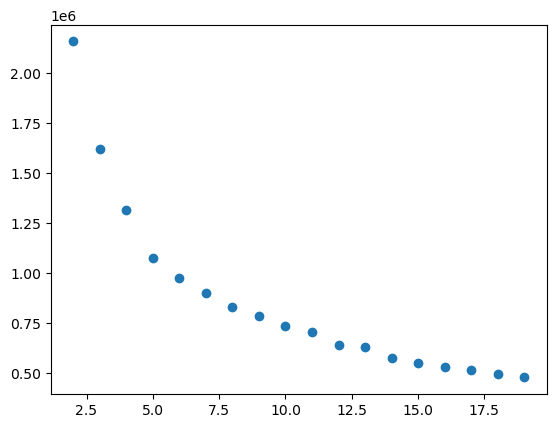

In [55]:
ks = range(2,20)
scores = []
for k in ks:
    model = KMeans(init="random", n_clusters=k, n_init=10, random_state=42).fit(feature_df)
    score = model.inertia_
    scores.append(score)
plt.scatter(ks, scores)

In [56]:
bestk = 5
model = KMeans(init="random", n_clusters=bestk, n_init=10, random_state=42).fit(feature_df)
df.info()
df['label'] = model.labels_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    float64
 3   dataset   920 non-null    float64
 4   cp        920 non-null    float64
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    float64
 8   restecg   920 non-null    float64
 9   thalch    920 non-null    float64
 10  exang     920 non-null    float64
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    float64
 13  ca        920 non-null    float64
 14  thal      920 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 107.9 KB


# Results

In [58]:
output = pd.read_csv('sample.csv')
df['exists'] = df['id'].isin(output['id'])
output_df = df[df['exists']==True]

In [59]:
dummy = output_df[['label']].to_numpy()
output[['cluster']] = dummy
output.to_csv('submission.csv',index=False)

# Conclusions

Using a variety of data cleaning methods makes clustering possible and conclusions may be drawn from this data once it can be clustered into patient populations.

Possibly a lower score could be achieved by using a regression method or random generation to fill the data with random values more effectively. More clinical knowledge about these various cardiology tests might also provide more insight into how to best impute these data, which highlights the importance of working with subject matter experts when constructing unsupervised learning methods.